In [188]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from pyVPRM.lib.fancy_plot import *
from rioxarray import merge
import numpy as np
import os
import glob
import xarray as xr
import shutil
import cartopy.crs as ccrs
import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import netCDF4 as nc
import pandas as pd
from scipy.interpolate import RegularGridInterpolator


# Evergreen Forest:
#     vprm_class: 1
#     class_numbers:
#         - 24  # Coniferous Forest

# Deciduous Forest:
#     vprm_class: 2
#     class_numbers:
#         - 23  # Broad-leaved Forest

# Mixed Forest:
#     vprm_class: 3
#     class_numbers:
#         - 25  # Mixed Forest
#         - 29  # Transitional Woodland-Shrub

# Shrubland:
#     vprm_class: 4
#     class_numbers:
#         - 27  # Moors and Heathland
#         - 28  # Sclerophyllous Vegetation

# Wetlands:
#     vprm_class: 5
#     class_numbers:
#         - 35  # Inland Marshes
#         - 36  # Peat Bogs
#         - 37  # Salt marshes

# Cropland:
#     vprm_class: 6
#     class_numbers:
#         - 12  # Non-irrigated Arable Land
#         - 13  # Permanently Irrigated Land
#         - 15  # Vineyards
#         - 16  # Fruit Trees and Berry Plantations
#         - 17  # Olive Groves
#         - 19  # Annual Crops Associated with Permanent Crops
#         - 20  # Complex Cultivation Patterns
#         - 21  # Land Principally Occupied by Agriculture
#         - 22  # Agro-forestry areas
#         - 14  # Rice Fields

# Grassland:
#     vprm_class: 7
#     class_numbers:
#       - 18  # Pastures
#       - 26  # Natural Grasslands

# Other:
#     vprm_class: 8
#     class_numbers:
#       - 1   # Continuous Urban Fabric
#       - 2   # Discontinuous Urban Fabric
#       - 3   # Industrial or Commercial Units
#       - 4   # Road and Rail Networks
#       - 5   # Port Areas
#       - 6   # Airports
#       - 7   # Mineral Extraction Sites
#       - 8   # Dump Sites
#       - 9   # Construction Sites
#       - 10  # Green Urban Areas
#       - 11  # Sport and Leisure Facilities
#       - 30  # Beaches, Dunes, Sands
#       - 31  # Bare Rocks
#       - 32  # Sparsely Vegetated Areas
#       - 33  # Burnt Areas
#       - 34  # Glaciers and Perpetual Snow
#       - 38  # Salines
#       - 39  # Intertidal flats
#       - 40  # Water courses
#       - 41  # Water bodies
#       - 42  # Coastal lagoons
#       - 43  # Estuaries
#       - 44  # Estuaries


# Find the closest grid point with same PFT for each site
def find_nearest_grid_pft(lat_target, lon_target, lats, lons, location_pft, IVGTYP_vprm):
    """Find the nearest grid index for a given lat/lon with the same PFT."""
    # Mask grid points that do not match the PFT
    valid_mask = IVGTYP_vprm == location_pft

    # Get valid lat/lon values
    valid_lats = np.where(valid_mask, lats, np.nan)
    valid_lons = np.where(valid_mask, lons, np.nan)

    # Convert latitude and longitude differences to km
    lat_diff = (
        valid_lats - lat_target
    )  # * 111  # approximate conversion factor for degrees to km
    lon_diff = (
        valid_lons - lon_target  # * 111 * np.cos(np.radians(lat_target))
    )  # adjust for latitude
    dist = np.sqrt(lat_diff**2 + lon_diff**2)
    dist_km = dist * 111
    # approximate conversion factor for degrees to km

    # Find the index of the minimum valid distance
    min_index = np.unravel_index(np.nanargmin(dist), lats.shape)

    # # Debugging prints
    # print(f"Target lat/lon: ({lat_target}, {lon_target})")
    # print(f"Valid lats: min={np.nanmin(valid_lats)}, max={np.nanmax(valid_lats)}")
    # print(f"Valid lons:  min={np.nanmin(valid_lons)}, max={np.nanmax(valid_lons)}")
    # print(f"Latitude differences: min={np.nanmin(lat_diff)}, max={np.nanmax(lat_diff)}")
    # print(f"Longitude differences: min={np.nanmin(lon_diff)}, max={np.nanmax(lon_diff)}")
    # print(f"Distances: min={np.nanmin(dist)}, max={np.nanmax(dist)}")
    # print(f"Distances (km): min={np.nanmin(dist_km)}, max={np.nanmax(dist_km)}")

    return np.nanmin(dist_km), min_index

# Find the closest grid point for each site
def find_nearest_grid(lat, lon, lats, lons):
    """Find the nearest grid index for a given lat/lon."""
    dist = np.sqrt((lats - lat)**2 + (lons - lon)**2)
    return np.unravel_index(np.argmin(dist), lats.shape)

def get_int_var(lat_target, lon_target, lats, lons, WRF_var):
    interpolator = RegularGridInterpolator((lats[:, 0], lons[0, :]), WRF_var)
    interpolated_value = interpolator((lat_target, lon_target))
    return interpolated_value

In [189]:
############# INPUT ############
domain = "_d01"
dx = "_54km" 
base_mz =  '/scratch/c7071034/DATA/pyVPRM/pyVPRM_examples/wrf_preprocessor/out'+domain+'_2012'+dx

if dx == "_3km" :
    wrfinput_path = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241230_093202_ALPS_3km/wrfinput"+domain
elif dx == "_9km" :
    wrfinput_path = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241229_064407_ALPS_9km/wrfinput"+domain
elif dx == "_27km" :
    wrfinput_path = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241229_112716_ALPS_27km/wrfinput"+domain
elif dx == "_54km" :
    wrfinput_path = "/scratch/c7071034/DATA/WRFOUT/WRFOUT_20241227_183215_ALPS_54km/wrfinput"+domain

t_file_fra = 'VPRM_input_VEG_FRA'+domain+'_2012.nc'
# t_file_fra = 'VPRM_input_VEG_FRA_2022.nc'

In [190]:
sites = [
    {"site": "CH-Oe2", "country": "Switzerland", "pft": "CRO", "pft_id": "6", "lat": 47.2863, "lon": 7.7343},
    {"site": "IT-Isp", "country": "Italy", "pft": "DBF", "pft_id": "2", "lat": 45.8126, "lon": 8.6336},
    {"site": "IT-PT1", "country": "Italy", "pft": "DBF", "pft_id": "2", "lat": 45.2009, "lon": 9.061},
    {"site": "CH-Dav", "country": "Switzerland", "pft": "ENF", "pft_id": "1", "lat": 46.8153, "lon": 9.8559},
    {"site": "DE-Lkb", "country": "Germany", "pft": "ENF", "pft_id": "1", "lat": 49.0996, "lon": 13.3047},
    {"site": "IT-La2", "country": "Italy", "pft": "ENF", "pft_id": "1", "lat": 45.9542, "lon": 11.2853},
    {"site": "IT-Lav", "country": "Italy", "pft": "ENF", "pft_id": "1", "lat": 45.9562, "lon": 11.2813},
    {"site": "IT-Ren", "country": "Italy", "pft": "ENF", "pft_id": "1", "lat": 46.5869, "lon": 11.4337},
    {"site": "AT-Neu", "country": "Austria", "pft": "GRA", "pft_id": "7", "lat": 47.1167, "lon": 11.3175},
    {"site": "CH-Cha", "country": "Switzerland", "pft": "GRA", "pft_id": "7", "lat": 47.2102, "lon": 8.4104},
    {"site": "CH-Fru", "country": "Switzerland", "pft": "GRA", "pft_id": "7", "lat": 47.1158, "lon": 8.5378},
    {"site": "CH-Oe1", "country": "Switzerland", "pft": "GRA", "pft_id": "7", "lat": 47.2858, "lon": 7.7319},
    {"site": "IT-MBo", "country": "Italy", "pft": "GRA", "pft_id": "7", "lat": 46.0147, "lon": 11.0458},
    {"site": "IT-Tor", "country": "Italy", "pft": "GRA", "pft_id": "7", "lat": 45.8444, "lon": 7.5781},
    {"site": "CH-Lae", "country": "Switzerland", "pft": "MF", "pft_id": "3", "lat": 47.4781, "lon": 8.3644},
    # {"site": "CZ-wet", "country": "Czech Republic", "pft": "WET", "pft_id": "8", "lat": 49.0247, "lon": 14.7704},
    # {"site": "DE-SfN", "country": "Germany", "pft": "WET", "pft_id": "8", "lat": 47.8064, "lon": 11.3275},
]


In [191]:
# CORINE vegetation type labels
vegetation_labels = [
    "Continuous Urban Fabric", "Discontinuous Urban Fabric", "Industrial or Commercial Units",
    "Road and Rail Networks", "Port Areas", "Airports", "Mineral Extraction Sites", 
    "Dump Sites", "Construction Sites", "Green Urban Areas", "Sport and Leisure Facilities", 
    "Non-irrigated Arable Land", "Permanently Irrigated Land", "Rice Fields", "Vineyards", 
    "Fruit Trees and Berry Plantations", "Olive Groves", "Pastures", "Annual Crops Associated with Permanent Crops",
    "Complex Cultivation Patterns", "Land Principally Occupied by Agriculture", "Agro-forestry Areas", 
    "Broad-leaved Forest", "Coniferous Forest", "Mixed Forest", "Natural Grasslands", "Moors and Heathland", 
    "Sclerophyllous Vegetation", "Transitional Woodland-Shrub", "Beaches, Dunes, Sands", "Bare Rocks",
    "Sparsely Vegetated Areas", "Burnt Areas", "Glaciers and Perpetual Snow", "Inland Marshes", 
    "Peat Bogs", "Salt Marshes", "Salines", "Intertidal Flats", "Water Courses", "Water Bodies",
    "Coastal Lagoons", "Estuaries"
]

# Define a color map for CORINE vegetation types
vegetation_colors = [
    "#FF0000", "#FF4500", "#B22222", "#808080", "#4682B4", "#87CEFA", "#8B4513", 
    "#A0522D", "#D2691E", "#32CD32", "#7FFF00", "#FFFF00", "#FFD700", "#F0E68C", "#8B0000", 
    "#B8860B", "#CD853F", "#ADFF2F", "#DDA0DD", "#F5DEB3", "#FFE4C4", "#DEB887", "#228B22", 
    "#006400", "#8FBC8F", "#7CFC00", "#556B2F", "#6B8E23", "#8B7500", "#F4A460", "#A9A9A9", 
    "#D3D3D3", "#FFFFFF", "#2E8B57", "#3CB371", "#20B2AA", "#5F9EA0", "#48D1CC", "#00CED1", 
    "#1E90FF", "#0000CD", "#4682B4", "#708090"
]

corine_to_vprm = {
    24: 1,            # Coniferous Forest (Evergreen)
    23: 2,            # Broad-leaved Forest (Deciduous)
    25: 3, 29: 3,     # Mixed Forest and Transitional Woodland-Shrub
    27: 4, 28: 4,     # Moors and Heathland, Sclerophyllous Vegetation (Shrubland)
    35: 5, 36: 5, 37: 5,  # Wetlands: Inland Marshes, Peat Bogs, Salt Marshes
    12: 6, 13: 6, 14: 6, 15: 6, 16: 6, 17: 6, 19: 6, 20: 6, 21: 6, 22: 6,  # Cropland
    18: 7, 26: 7,     # Grassland: Pastures, Natural Grasslands
    # Others mapped to 8 (gray)
    1: 8, 2: 8, 3: 8, 4: 8, 5: 8, 6: 8, 7: 8, 8: 8, 9: 8, 10: 8, 11: 8, 
    30: 8, 31: 8, 32: 8, 33: 8, 34: 8, 38: 8, 39: 8, 40: 8, 41: 8, 42: 8, 43: 8, 44: 8
}

# Define labels for the simplified vegetation types
labels_vprm_short = [
    "ENF", "DBF", "MF", "SHB", 
    "SAV", "CRO", "GRA", "OTH"  # Include "Others"
]

In [192]:
# # Load the NetCDF file
# nc_fid = nc.Dataset(wrfinput_path, "r")

# # Retrieve the CORINE vegetation types (IVGTYP) and coordinates (XLAT, XLONG)
# IVGTYP = nc_fid.variables['IVGTYP'][:]
# XLAT = nc_fid.variables['XLAT'][0]  # Assuming the first time slice
# XLONG = nc_fid.variables['XLONG'][0]
# IVGTYP_vprm = np.vectorize(corine_to_vprm.get)(IVGTYP[0,:, :])

# # Append model PFT to each site
# for site in sites:
#     lat, lon = site["lat"], site["lon"]
#     dist_km, grid_idx = find_nearest_grid_pft(lat, lon, XLAT, XLONG,int(site["pft_id"]),IVGTYP_vprm)
#     site["model_pft"] = IVGTYP[0,grid_idx[0],grid_idx[1]]
#     site["dist_km"] = dist_km

# # Convert to DataFrame for tabular output
# df = pd.DataFrame(sites)

# # Print the table
# print(df)
# nc_fid.close()


In [193]:
# Load the NetCDF file
nc_fid = nc.Dataset(wrfinput_path, "r")

# Retrieve the CORINE vegetation types (IVGTYP) and coordinates (XLAT, XLONG)
IVGTYP = nc_fid.variables['IVGTYP'][:]
XLAT = nc_fid.variables['XLAT'][0]  # Assuming the first time slice
XLONG = nc_fid.variables['XLONG'][0]
HGT_M = nc_fid.variables['HGT'][0]
IVGTYP_vprm = np.vectorize(corine_to_vprm.get)(
            IVGTYP[0,:, :])

# Append model PFT to each site
for site in sites:
    lat, lon = site["lat"], site["lon"]
    dist_km, grid_idx = find_nearest_grid_pft(lat, lon, XLAT, XLONG,int(site["pft_id"]),IVGTYP_vprm)
    site["model_pft"] = IVGTYP[0,grid_idx[0],grid_idx[1]]
    site["model_hgt_NN"] = HGT_M[grid_idx[0],grid_idx[1]]
    site["model_lat"] = XLAT[grid_idx[0],grid_idx[1]]
    site["model_lon"] = XLONG[grid_idx[0],grid_idx[1]]
    site["dist_km"] = dist_km
    site["model_pft_CLC"] = vegetation_labels[site["model_pft"]-1]
    site["model_pft_VPRM"] = labels_vprm_short[corine_to_vprm[site["model_pft"]]-1]
    if site["pft"] == site["model_pft_VPRM"]:
        site["pft_match"] = True
    else:
        site["pft_match"] = False

# Convert to DataFrame for tabular output
df_sites_match = pd.DataFrame(sites)

# Print the table
print(df_sites_match)
df_sites_match.to_csv("pft_site_match_at"+dx+".csv" )


      site      country  pft pft_id      lat      lon  model_pft  \
0   CH-Oe2  Switzerland  CRO      6  47.2863   7.7343         12   
1   IT-Isp        Italy  DBF      2  45.8126   8.6336         23   
2   IT-PT1        Italy  DBF      2  45.2009   9.0610         23   
3   CH-Dav  Switzerland  ENF      1  46.8153   9.8559         24   
4   DE-Lkb      Germany  ENF      1  49.0996  13.3047         24   
5   IT-La2        Italy  ENF      1  45.9542  11.2853         24   
6   IT-Lav        Italy  ENF      1  45.9562  11.2813         24   
7   IT-Ren        Italy  ENF      1  46.5869  11.4337         24   
8   AT-Neu      Austria  GRA      7  47.1167  11.3175         18   
9   CH-Cha  Switzerland  GRA      7  47.2102   8.4104         26   
10  CH-Fru  Switzerland  GRA      7  47.1158   8.5378         26   
11  CH-Oe1  Switzerland  GRA      7  47.2858   7.7319         26   
12  IT-MBo        Italy  GRA      7  46.0147  11.0458         26   
13  IT-Tor        Italy  GRA      7  45.8444   7

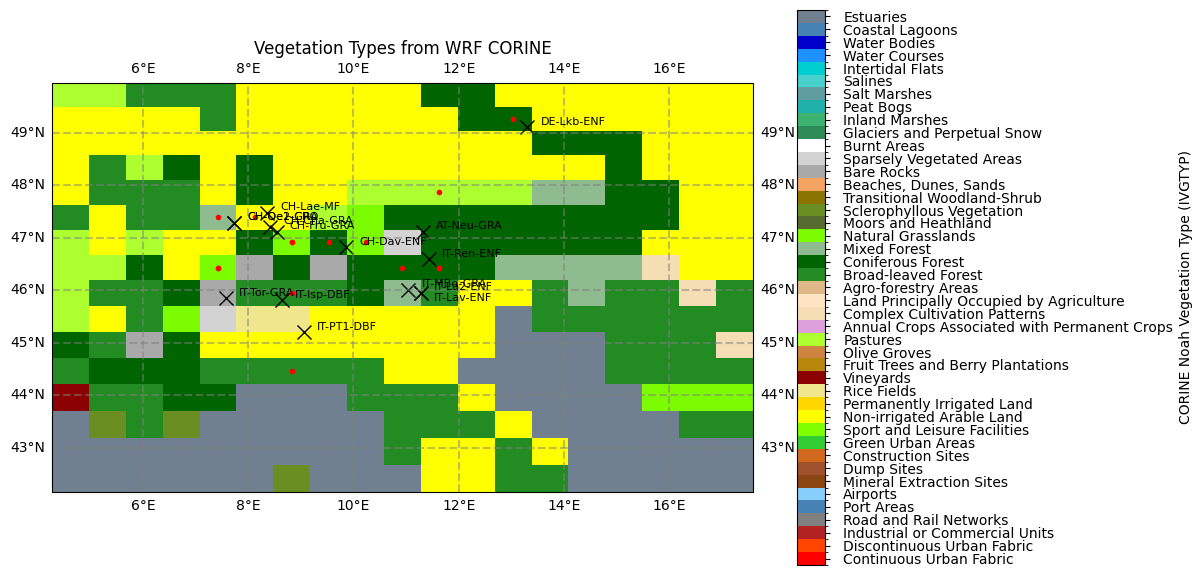

In [194]:

# Create color map and boundaries for  CORINE types
cmap_vegetation = mcolors.ListedColormap(vegetation_colors)
bounds_vegetation = list(range(1, 45))  # Vegetation types (1–44), extra bin to close the range
norm_vegetation = mcolors.BoundaryNorm(bounds_vegetation, cmap_vegetation.N)

# Plot the vegetation map using the CORINE  classification
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot using pcolormesh with XLAT and XLONG as coordinates and shading='auto'
vegetation_plot = ax.pcolormesh(
    XLONG, XLAT, IVGTYP[0, :, :],  # Use first time slice of IVGTYP for 2D data
    cmap=cmap_vegetation, norm=norm_vegetation, transform=ccrs.PlateCarree(), shading='auto'
)

# Add colorbar with vegetation labels
cbar = fig.colorbar(vegetation_plot, ax=ax, ticks=np.arange(1, 44)+0.5, orientation='vertical')
cbar.ax.set_yticklabels(vegetation_labels)
cbar.ax.set_ylabel('CORINE Noah Vegetation Type (IVGTYP)')
legend_entries = []

# Plot markers for each site
for index, site in df_sites_match.iterrows():
    label = f"{site['site']}-{site['pft']}"  # Create label as 'site-pft'

    # Adjust specific label positions if necessary
    if site["site"] == "IT-Lav":
        text_offset_x, text_offset_y = 0.25, -0.1
    else:
        text_offset_x, text_offset_y = 0.25, 0.1

    # Plot the marker
    ax.plot(
        site["lon"], site["lat"],
        marker='x',
        color = 'black',
        markersize=10,
        linewidth=2,
        transform=ccrs.PlateCarree()
    )
    ax.plot(
        site["model_lon"], site["model_lat"],
        marker='o',
        color = 'red',
        markersize=3,
        linewidth=2,
        transform=ccrs.PlateCarree()
    )

    # Add the label
    ax.text(
        site["lon"] + text_offset_x, site["lat"] + text_offset_y,
        label,
        color='black',
        transform=ccrs.PlateCarree(),
        fontsize=8,
        ha='left',
        va='center'
    )

# Set title and gridlines
ax.set_title("Vegetation Types from WRF CORINE")
gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
plt.tight_layout()
plt.savefig(f"VGT_CORINE_{domain+dx}.png")
plt.show()



In [195]:

in_veg_frac = xr.open_dataset(os.path.join(base_mz, t_file_fra))

# Select the 'vprm_classes' slice where it equals 8
veg_frac_map = in_veg_frac['vegetation_fraction_map']
veg_frac_class_8 = veg_frac_map.sel(vprm_classes=8)

# Create a mask for IVGTYP where the condition is met
mask_ivgtyp = (IVGTYP[0, :, :] == 44)

# Apply the mask to overwrite the vegetation_fraction_map
veg_frac_class_8 = veg_frac_class_8.where(~mask_ivgtyp, 1)

# Update only the 'vprm_classes=8' slice in the original DataArray
veg_frac_map.loc[{'vprm_classes': 8}] = veg_frac_class_8

# Update the DataArray in the dataset
in_veg_frac['vegetation_fraction_map'] = veg_frac_map
# VEGTYPES:
# 1) evergreen, 2) deciduous, 3) mixed forest,4) shrubland, 5) savannas, 6) cropland, 7) grassland, and 8) others

# # Define the bins and normalize
# cmap = plt.cm.inferno_r
# cmaplist = [cmap(i) for i in range(cmap.N)]
# cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
# bounds = np.linspace(0, 1, 11)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# # Loop through the vegetation classes
# for i in range(1, 9):
#     # Create a new figure for each vegetation class
#     fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    
#     # Plot the vegetation fraction map for the current class
#     cb = in_veg_frac.sel({'vprm_classes': i})['vegetation_fraction_map'].plot.pcolormesh(
#         cmap=cmap, ax=ax, x='lon', y='lat', vmin=0, vmax=1.0, add_colorbar=False
#     )
    
#     ax.set_title(f'Vegetation Class {i}')
    
#     # Set limits
#     lats = in_veg_frac['lat'].values.flatten()
#     lons = in_veg_frac['lon'].values.flatten()
#     ax.set_xlim(np.min(lons), np.max(lons))
#     ax.set_ylim(np.min(lats), np.max(lats))
    
#     # Add gridlines
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                       linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
#     gl.xlabels_top = False
#     gl.ylabels_right = False
    
#     # Add colorbar
#     axins = inset_axes(ax, width="5%", height="90%", loc='center right', borderpad=-5)
#     cbar = fig.colorbar(cb, cax=axins)
#     cbar.ax.get_yaxis().labelpad = 15
#     cbar.ax.set_ylabel('Vegetation Fraction', rotation=270)
#     ax.plot(lon_target, lat_target, marker='x', color='blue', markersize=20, transform=ccrs.PlateCarree(), label='FluxNet Tower')
#     ax.legend()
#     # Show the figure
#     plt.tight_layout()
#     plt.savefig(f"VGT_frac_VPRM_compare_{i}_{domain+dx}.png")
#     plt.show()



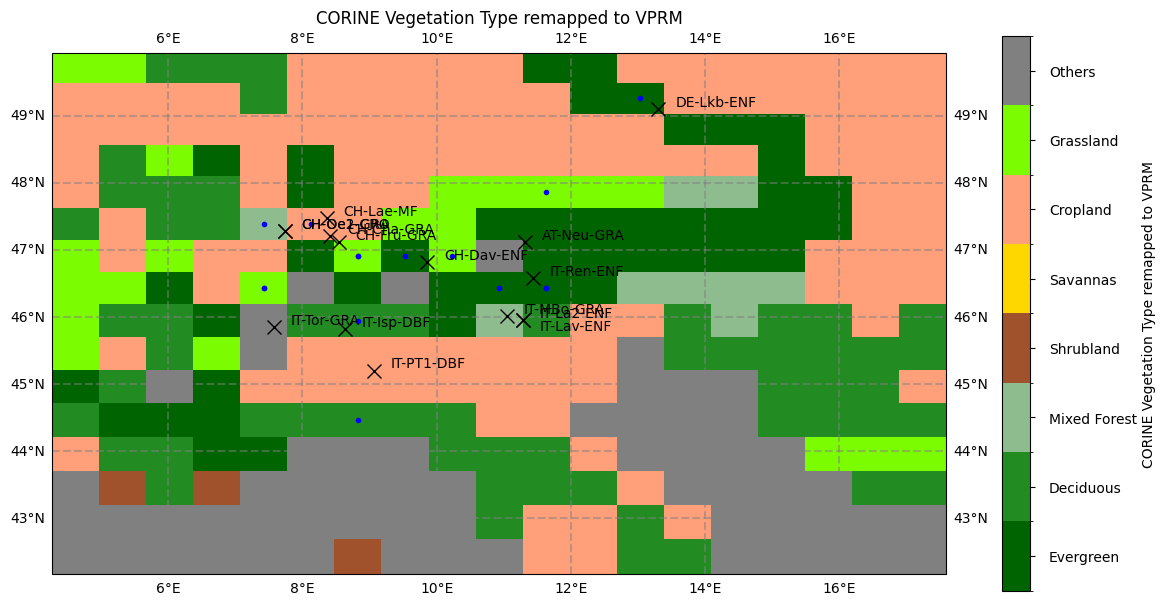

In [196]:


# Define the colors for the vegetation types (7 colors + gray for 8 others)
custom_colors = ["#006400", "#228B22", "#8FBC8F", "#A0522D", 
                 "#FFD700", "#FFA07A", "#7CFC00", "#808080"]  # Added gray for "Others"

# Create a colormap using the defined colors
cmap_simplified = mcolors.ListedColormap(custom_colors)

# Define the remapping dictionary for CORINE vegetation types
corine_to_vprm = {
    24: 1,            # Coniferous Forest (Evergreen)
    23: 2,            # Broad-leaved Forest (Deciduous)
    25: 3, 29: 3,     # Mixed Forest and Transitional Woodland-Shrub
    27: 4, 28: 4,     # Moors and Heathland, Sclerophyllous Vegetation (Shrubland)
    35: 5, 36: 5, 37: 5,  # Wetlands: Inland Marshes, Peat Bogs, Salt Marshes
    12: 6, 13: 6, 14: 6, 15: 6, 16: 6, 17: 6, 19: 6, 20: 6, 21: 6, 22: 6,  # Cropland
    18: 7, 26: 7,     # Grassland: Pastures, Natural Grasslands
    # Others mapped to 8 (gray)
    1: 8, 2: 8, 3: 8, 4: 8, 5: 8, 6: 8, 7: 8, 8: 8, 9: 8, 10: 8, 11: 8, 
    30: 8, 31: 8, 32: 8, 33: 8, 34: 8, 38: 8, 39: 8, 40: 8, 41: 8, 42: 8, 43: 8, 44: 8
}


# Create a new array for the simplified vegetation categories
IVGTYP_simplified = np.vectorize(corine_to_vprm.get)(IVGTYP[0, :, :])

# Plot the simplified vegetation type map
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})
vegetation_plot = ax.pcolormesh(
    XLONG, XLAT, IVGTYP_simplified, 
    cmap=cmap_simplified, 
    norm=mcolors.BoundaryNorm(np.arange(1, 10), cmap_simplified.N), 
    transform=ccrs.PlateCarree(), shading='auto'
)

# Define labels for the simplified vegetation types
labels_vprm = [
    "Evergreen", "Deciduous", "Mixed Forest", "Shrubland", 
    "Savannas", "Cropland", "Grassland", "Others"  # Include "Others"
]

# Add color bar with simplified vegetation labels
cbar = fig.colorbar(vegetation_plot, ax=ax, ticks=np.arange(1, 9)+0.5, orientation='vertical')
cbar.ax.set_yticklabels(labels_vprm)
cbar.set_label("CORINE Vegetation Type remapped to VPRM")
gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

# Plot markers for each site
for index, site in df_sites_match.iterrows():
    label = f"{site['site']}-{site['pft']}"  # Create label as 'site-pft'

    # Adjust specific label positions if necessary
    if site["site"] == "IT-Lav":
        text_offset_x, text_offset_y = 0.25, -0.1
    else:
        text_offset_x, text_offset_y = 0.25, 0.1

    # Plot the marker
    ax.plot(
        site["lon"], site["lat"],
        marker='x',
        color = 'black',
        markersize=10,
        linewidth=2,
        transform=ccrs.PlateCarree()
    )
    ax.plot(
        site["model_lon"], site["model_lat"],
        marker='o',
        color = 'blue',
        markersize=3,
        linewidth=2,
        transform=ccrs.PlateCarree()
    )


    # Add the label
    ax.text(
        site["lon"] + text_offset_x, site["lat"] + text_offset_y,
        label,
        color='black',
        transform=ccrs.PlateCarree(),
        fontsize=10,
        ha='left',
        va='center'
    )

# Add title and show plot
ax.set_title("CORINE Vegetation Type remapped to VPRM")
plt.tight_layout()
plt.savefig(f"VGT_CORINE_remapped_VPRM_{domain+dx}.png")
plt.show()



In [197]:

# Replace fractions below 0.1 with NaN
# in_veg_frac['vegetation_fraction_map'].values[in_veg_frac['vegetation_fraction_map'].values < 0.1] = np.nan

# Find the vegetation type with the maximum fraction for each grid cell
max_veg_type = in_veg_frac['vegetation_fraction_map'].argmax(dim='vprm_classes') + 1


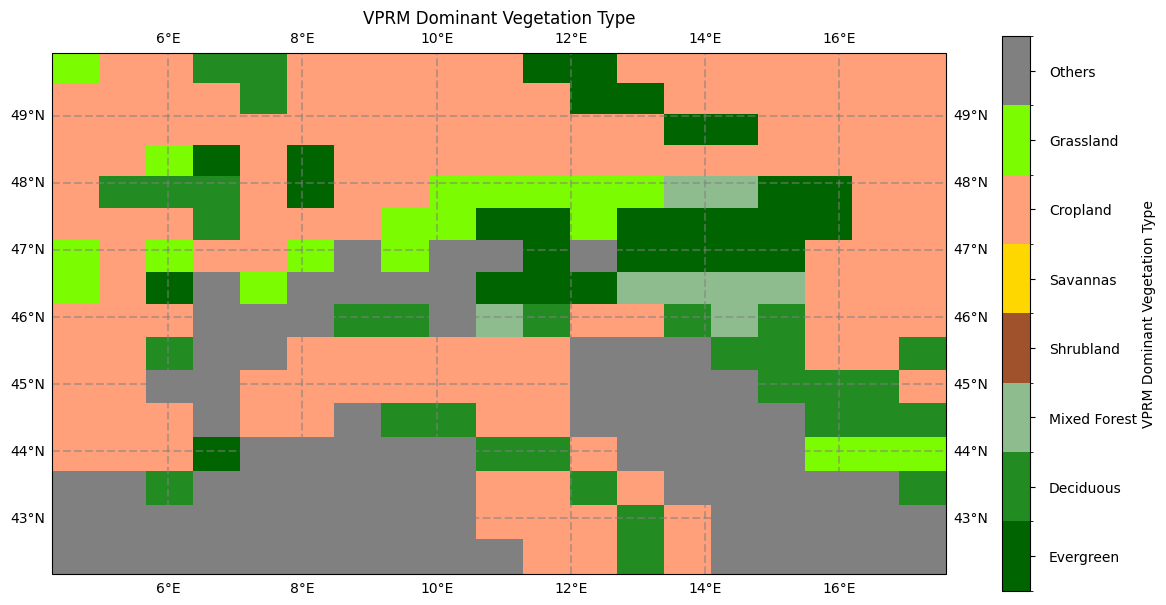

In [198]:

# Convert to DataFrame for ease of use
df_veg_type = max_veg_type.to_dataframe(name='vegetation_type').reset_index()


# Define vegetation type labels
veg_labels = [
    "Evergreen", "Deciduous", "Mixed Forest", "Shrubland", 
    "Savannas", "Cropland", "Grassland", "Others"
]

# Define a color map with 8 distinct colors for the vegetation types
colors = ["#006400", "#228B22", "#8FBC8F", "#A0522D", 
          "#FFD700", "#FFA07A", "#7CFC00", "#808080"]  # Including gray for "Others"
cmap = mcolors.ListedColormap(colors)

# Boundaries for each vegetation type (1 to 8, with an extra to close the last bin)
bounds = list(range(1, 10))
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Pivot the DataFrame to create 2D arrays for plotting
veg_2d = df_veg_type.pivot(index='lat', columns='lon', values='vegetation_type')

# Replace NaNs with a value that is not used in the colormap, e.g., 0 (if not already a valid type)
veg_2d.fillna(0, inplace=True)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the vegetation type map with pcolormesh
veg_plot = ax.pcolormesh(
    veg_2d.columns.values,  # Longitudes
    veg_2d.index.values,    # Latitudes
    veg_2d.values,          # 2D grid of vegetation types
    cmap=cmap, norm=norm, transform=ccrs.PlateCarree()
)

# Add colorbar with labels
cbar = fig.colorbar(veg_plot, ax=ax, ticks=np.arange(1, 9)+0.5, orientation='vertical')
cbar.ax.set_yticklabels(veg_labels)
cbar.ax.set_ylabel('VPRM Dominant Vegetation Type')
# Set title and gridlines
ax.set_title("VPRM Dominant Vegetation Type")
gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
plt.tight_layout()
plt.savefig(f"VGT_VPRM_{domain+dx}.png")
plt.show()


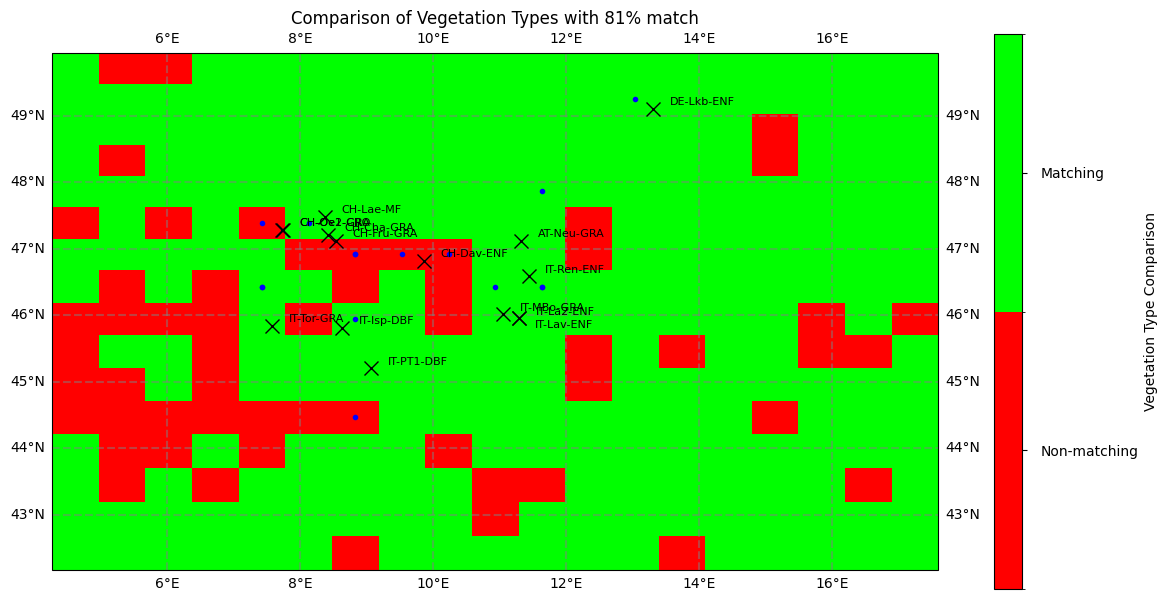

In [199]:

# Create a comparison array where vegetation types match (1) or don't match (0)
comparison_array = np.where(max_veg_type.values == IVGTYP_simplified, 1, 0)

# Define colors for the comparison map
comparison_colors = [ "#FF0000","#00FF00"]  # Green for matching, Red for non-matching

# Create a colormap for the comparison
cmap_comparison = mcolors.ListedColormap(comparison_colors)

# Set the boundaries for the color normalization
bounds_comparison = [-0.5, 0.5, 1.5]  # Create bins for 0 and 1
norm_comparison = mcolors.BoundaryNorm(bounds_comparison, cmap_comparison.N)

# Create the plot for the comparison
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the comparison array using pcolormesh
comparison_plot = ax.pcolormesh(
    XLONG, XLAT, comparison_array, 
    cmap=cmap_comparison, 
    norm=norm_comparison, 
    transform=ccrs.PlateCarree(), 
    shading='auto'
)

# Add colorbar for the comparison
cbar = fig.colorbar(comparison_plot, ax=ax, ticks=[0, 1], orientation='vertical')
cbar.ax.set_yticklabels(['Non-matching', 'Matching'])
cbar.set_label('Vegetation Type Comparison')

percent_equal = comparison_array.sum()/(comparison_array.shape[0]*comparison_array.shape[1])*100

# Set title and gridlines
ax.set_title(f"Comparison of Vegetation Types with {int(percent_equal)}% match")
gl = ax.gridlines(draw_labels=True, linewidth=1.5, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


# Plot markers for each site
for index, site in df_sites_match.iterrows():
    label = f"{site['site']}-{site['pft']}"  # Create label as 'site-pft'

    # Adjust specific label positions if necessary
    if site["site"] == "IT-Lav":
        text_offset_x, text_offset_y = 0.25, -0.1
    else:
        text_offset_x, text_offset_y = 0.25, 0.1

    # Plot the marker
    ax.plot(
        site["lon"], site["lat"],
        marker='x',
        color = 'black',
        markersize=10,
        linewidth=2,
        transform=ccrs.PlateCarree()
    )
    ax.plot(
        site["model_lon"], site["model_lat"],
        marker='o',
        color = 'blue',
        markersize=3,
        linewidth=2,
        transform=ccrs.PlateCarree()
    )


    # Add the label
    ax.text(
        site["lon"] + text_offset_x, site["lat"] + text_offset_y,
        label,
        color='black',
        transform=ccrs.PlateCarree(),
        fontsize=8,
        ha='left',
        va='center'
    )
    
plt.tight_layout()
plt.savefig(f"VGT_VPRM_compare_{domain+dx}.png")
plt.show()
